In [11]:
#!/usr/bin/env python
# coding: utf-8

##### libraries
## 3rd party
from __future__ import print_function
import pywt
import math
import numpy as np
import matplotlib.pyplot as plt
import copy
import pdb
import csv
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
torch.set_default_tensor_type(torch.DoubleTensor)

# ignore package deprecation warnings
import warnings
warnings.filterwarnings("ignore")

## custom
from utils.data_formatting import HDF5Dataset
from utils.common import *

In [12]:
# import matplotlib.font_manager
# from IPython.core.display import HTML

# def make_html(fontname):
#     return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

# code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

# HTML("<div style='column-count: 2;'>{}</div>".format(code))

In [13]:
##### parameters
val_fold = 4
bs = 32
b=12

In [14]:
dset_train = CINC7Dataset('../data/custom/physionet2017_4classes.hdf5',train=True,transform=DWT(4))
dset_val = CINC7Dataset('../data/custom/physionet2017_4classes.hdf5',train=False,transform=DWT(4))

dl_train = DataLoader(dset_train, batch_size=bs, shuffle=False, num_workers=0)
dl_val = DataLoader(dset_val, batch_size=bs, shuffle=False, num_workers=0)

In [15]:
##### main code
# load networks
model_path = f'snn_ref/model_fold{val_fold}.pt'
cnn = WVCNN4()
cnn.load_state_dict(torch.load(model_path).state_dict(), strict=False)
cnn_bninteg = WVCNN4()
cnn_bninteg.normed = True
cnn_bninteg.load_state_dict(cnn.state_dict())

<All keys matched successfully>

In [16]:
#"""
# import and format physionet data
data_raw = HDF5Dataset('../data/custom/physionet2017_4classes.hdf5', True)

# convert to slicable data
ecgs = torch.empty(len(data_raw),18000)
dwts = torch.empty(len(data_raw),2,1127)
lbls = torch.empty(len(data_raw))
for ii,data in enumerate(tqdm(data_raw)):
    if len(data[0][0]) >= 18000:
        data_in = data[0][:,0:18000]
    else:
        data_in = torch.zeros((1,18000))
        data_in[0,0:len(data[0][0])] = data[0]
    ecgs[ii,:] = data_in
    dwt_tmp = pywt.wavedec(data_in,'db2',level=4)
    dwts[ii,:,:] = torch.tensor(np.concatenate((dwt_tmp[0],dwt_tmp[1]),0))
    lbls[ii] = data[1]
#"""

100%|██████████| 8528/8528 [00:18<00:00, 473.14it/s]


In [17]:
#"""
# get train/test for normalization
fold_idx = split_into_5folds(lbls)
train_idx = (fold_idx!=val_fold)
val_idx = (fold_idx==val_fold)

dwt_val = dwts[val_idx].unsqueeze(1)
dwt_train = dwts[train_idx].unsqueeze(1)

lbl_val = lbls[val_idx].long()
lbl_train = lbls[train_idx].long()
#"""

In [18]:
# reference cnn
cnn.eval()
F1t_ref = eval_model(cnn, dl_train)

  1%|          | 2/214 [00:00<00:17, 12.39it/s]

tensor([[ 3.9823, -2.5904,  1.3450, -2.6394],
        [ 1.6625, -1.1305,  0.0781, -0.5590],
        [ 2.7647, -1.9413,  1.5864, -2.3459],
        [-1.0916,  2.4546,  1.2464, -2.4800],
        [-6.4831,  6.2422,  4.1548, -3.5330],
        [ 3.3940, -1.9636,  1.2760, -2.6138],
        [ 2.8489, -1.6963,  1.2443, -2.3048],
        [ 0.7253, -1.7211,  3.9823, -2.7965],
        [-1.6297,  2.6756,  1.2523, -2.2148],
        [ 3.4396, -2.1567,  1.3556, -2.5755],
        [ 3.1832, -2.4899,  0.7178, -1.3202],
        [ 1.8077, -0.5990,  0.9713, -2.0974],
        [ 0.7826, -0.6839,  2.6665, -2.6246],
        [ 2.1624, -1.9558,  0.5401, -0.6635],
        [-0.0517, -0.6707,  0.3256,  0.4001],
        [ 3.0525, -1.9447,  1.1915, -2.2090],
        [-0.9487,  0.5379,  1.4396, -0.9285],
        [ 3.7117, -2.6453,  1.4011, -2.3729],
        [ 3.9878, -2.5335,  1.8307, -3.1940],
        [ 0.4743, -0.0350,  2.2797, -2.5863],
        [ 3.5353, -2.2247,  1.5681, -2.7839],
        [ 0.1676, -1.4120, -0.4102

100%|██████████| 214/214 [00:15<00:00, 13.72it/s]

Total: 0.8193543553352356, N: 0.9157466292381287, AF: 0.7904191613197327, O: 0.7518972754478455, ACC: 0.8562005277044855


In [19]:
# reference including batchnormalization in weights and biases
cnn_bninteg.eval()
cnn_bninteg.update_weights_bn_integration()
F1t_trans1 = eval_model(cnn_bninteg, dl_train)

  0%|          | 1/214 [00:00<00:25,  8.44it/s]

tensor([[ 4.1285, -2.6979,  1.4046, -2.7350],
        [ 1.6965, -1.1737,  0.0738, -0.5448],
        [ 2.8017, -1.9906,  1.6724, -2.4167],
        [-1.2256,  2.6460,  1.3387, -2.6242],
        [-6.9312,  6.6343,  4.4496, -3.7523],
        [ 3.5037, -2.0247,  1.3318, -2.7151],
        [ 2.9243, -1.7413,  1.2975, -2.3855],
        [ 0.6537, -1.7793,  4.2351, -2.9101],
        [-1.7985,  2.8865,  1.3479, -2.3501],
        [ 3.5371, -2.2165,  1.4090, -2.6641],
        [ 3.2866, -2.6209,  0.7365, -1.3078],
        [ 1.8119, -0.5589,  1.0084, -2.1762],
        [ 0.7365, -0.6769,  2.8164, -2.7312],
        [ 2.2240, -2.0495,  0.5649, -0.6539],
        [-0.1134, -0.7156,  0.3655,  0.4659],
        [ 3.1472, -2.0157,  1.2431, -2.2816],
        [-1.0870,  0.6095,  1.5176, -0.9358],
        [ 3.8247, -2.7628,  1.4768, -2.4421],
        [ 4.1131, -2.6183,  1.9171, -3.3181],
        [ 0.4018,  0.0250,  2.4162, -2.7055],
        [ 3.6430, -2.3017,  1.6427, -2.8863],
        [ 0.1385, -1.5487, -0.4438

100%|██████████| 214/214 [00:15<00:00, 13.90it/s]

Total: 0.8192494511604309, N: 0.9170172810554504, AF: 0.7866894006729126, O: 0.7540415525436401, ACC: 0.8569334506009968


In [20]:
# save BN integrated model for other conversion methodologies
#model_path_bnintegr = f'snn_ref/model_fold{val_fold}_bnintegr.pt'
#torch.save(cnn_bninteg, model_path_bnintegr)

In [21]:
# normed model such that input and activations are in [0,1]
cnn_normed = WVCNN4()
cnn_normed.load_state_dict(cnn_bninteg.state_dict())

<All keys matched successfully>

In [22]:
cnn_normed.calculate_norm_values(dwt_train)
cnn_normed.print_norm_values()
cnn_normed.update_weights_with_norm_values()

input: lmbda=0.015740190112859882,dlta=0.4815042797031844
conv1: lmbda=0.06884055279420398,dlta=0
conv2: lmbda=0.030128361216034467,dlta=0
conv3: lmbda=0.10911830024841578,dlta=0
conv4: lmbda=0.011991655693616932,dlta=0
fc: lmbda=0.034707566470272226,dlta=0


In [23]:
# save input norm vals
np.save('snn_ref/model_norm_params.npy', [cnn_normed.input_lmbda, cnn_normed.input_dlta])

In [24]:
# prepare dataloader with normalization of input
dsetn_train = CINC7Dataset('../data/custom/physionet2017_4classes.hdf5',train=True,transform=DWTnNorm(4,cnn_normed.input_lmbda,cnn_normed.input_dlta,quant=False))
dsetn_val = CINC7Dataset('../data/custom/physionet2017_4classes.hdf5',train=False,transform=DWTnNorm(4,cnn_normed.input_lmbda,cnn_normed.input_dlta,quant=False))

dln_train = DataLoader(dsetn_train, batch_size=bs, shuffle=False, num_workers=0)
dln_val = DataLoader(dsetn_val, batch_size=bs, shuffle=False, num_workers=0)

In [25]:
cnn_normed.eval()
F1t_trans2 = eval_model(cnn_normed, dln_train)

  1%|          | 2/214 [00:00<00:15, 13.73it/s]

tensor([[ 0.1433, -0.0936,  0.0488, -0.0949],
        [ 0.0589, -0.0407,  0.0026, -0.0189],
        [ 0.0972, -0.0691,  0.0580, -0.0839],
        [-0.0425,  0.0918,  0.0465, -0.0911],
        [-0.2406,  0.2303,  0.1544, -0.1302],
        [ 0.1216, -0.0703,  0.0462, -0.0942],
        [ 0.1015, -0.0604,  0.0450, -0.0828],
        [ 0.0227, -0.0618,  0.1470, -0.1010],
        [-0.0624,  0.1002,  0.0468, -0.0816],
        [ 0.1228, -0.0769,  0.0489, -0.0925],
        [ 0.1141, -0.0910,  0.0256, -0.0454],
        [ 0.0629, -0.0194,  0.0350, -0.0755],
        [ 0.0256, -0.0235,  0.0977, -0.0948],
        [ 0.0772, -0.0711,  0.0196, -0.0227],
        [-0.0039, -0.0248,  0.0127,  0.0162],
        [ 0.1092, -0.0700,  0.0431, -0.0792],
        [-0.0377,  0.0212,  0.0527, -0.0325],
        [ 0.1327, -0.0959,  0.0513, -0.0848],
        [ 0.1428, -0.0909,  0.0665, -0.1152],
        [ 0.0139,  0.0009,  0.0839, -0.0939],
        [ 0.1264, -0.0799,  0.0570, -0.1002],
        [ 0.0048, -0.0538, -0.0154

100%|██████████| 214/214 [00:15<00:00, 13.78it/s]

Total: 0.8192494511604309, N: 0.9170172810554504, AF: 0.7866894006729126, O: 0.7540415525436401, ACC: 0.8569334506009968


In [26]:
# Save final model 
#model_path_normed = f'snn_ref/model_fold{val_fold}_norm.pt'
#torch.save(cnn_normed, model_path_normed)

In [27]:
# plot weight & bias distribution as preparation for quantization
# plt.figure(0,figsize=[25,5])
# ax1 = plt.subplot(1, 5, 1)
# plt.hist(cnn_normed.conv1.weight.flatten(),range=(-5,5),bins=20)
# ax1 = plt.subplot(1, 5, 2)
# plt.hist(cnn_normed.conv2.weight.flatten(),range=(-5,5),bins=20)
# ax1 = plt.subplot(1, 5, 3)
# plt.hist(cnn_normed.conv3.weight.flatten(),range=(-5,5),bins=20)
# ax1 = plt.subplot(1, 5, 4)
# plt.hist(cnn_normed.conv4.weight.flatten(),range=(-5,5),bins=20)
# ax1 = plt.subplot(1, 5, 5)
# plt.hist(cnn_normed.fc.weight.flatten(),range=(-5,5),bins=20);

In [28]:
# plt.figure(0,figsize=[25,5])
# ax1 = plt.subplot(1, 5, 1)
# plt.hist(cnn_normed.conv1.bias.flatten(),range=(-5,5),bins=20)
# ax1 = plt.subplot(1, 5, 2)
# plt.hist(cnn_normed.conv2.bias.flatten(),range=(-5,5),bins=20)
# ax1 = plt.subplot(1, 5, 3)
# plt.hist(cnn_normed.conv3.bias.flatten(),range=(-5,5),bins=20)
# ax1 = plt.subplot(1, 5, 4)
# plt.hist(cnn_normed.conv4.bias.flatten(),range=(-5,5),bins=20)
# ax1 = plt.subplot(1, 5, 5)
# plt.hist(cnn_normed.fc.bias.flatten(),range=(-5,5),bins=20);

In [29]:
# NN in fixed point only
#b=16

cnn_quant = WVCNN4()
cnn_quant.load_state_dict(cnn_normed.state_dict())
#cnn_quant = cnn_normed
cnn_quant.update_weights_with_quant(b=b) # number of fractional bits for weights and bias
cnn_quant.q_actb = b # number of fractional bits for activations
cnn_quant.quantize = True
cnn_quant.normed = True

In [30]:
cnn_quant.eval()
eval_model(cnn_quant, dln_train)

  0%|          | 1/214 [00:00<00:23,  9.21it/s]

tensor([[ 0.1396, -0.0911,  0.0469, -0.0923],
        [ 0.0576, -0.0405,  0.0020, -0.0173],
        [ 0.0928, -0.0635,  0.0535, -0.0806],
        [-0.0413,  0.0913,  0.0447, -0.0903],
        [-0.2402,  0.2317,  0.1538, -0.1313],
        [ 0.1165, -0.0662,  0.0454, -0.0925],
        [ 0.0996, -0.0583,  0.0449, -0.0828],
        [ 0.0203, -0.0576,  0.1418, -0.0977],
        [-0.0640,  0.1018,  0.0439, -0.0791],
        [ 0.1196, -0.0737,  0.0471, -0.0911],
        [ 0.1121, -0.0903,  0.0232, -0.0417],
        [ 0.0552, -0.0120,  0.0344, -0.0745],
        [ 0.0232, -0.0195,  0.0945, -0.0933],
        [ 0.0752, -0.0691,  0.0176, -0.0208],
        [-0.0042, -0.0234,  0.0105,  0.0168],
        [ 0.1062, -0.0674,  0.0425, -0.0784],
        [-0.0415,  0.0237,  0.0500, -0.0288],
        [ 0.1284, -0.0906,  0.0449, -0.0796],
        [ 0.1387, -0.0854,  0.0623, -0.1125],
        [ 0.0095,  0.0056,  0.0825, -0.0928],
        [ 0.1218, -0.0762,  0.0549, -0.0974],
        [ 0.0007, -0.0515, -0.0149

100%|██████████| 214/214 [00:16<00:00, 12.78it/s]

Total: 0.8164928555488586, N: 0.9182478189468384, AF: 0.7816666960716248, O: 0.7495642304420471, ACC: 0.8560539431251832


(tensor(0.8165, dtype=torch.float32),
 tensor(0.9182, dtype=torch.float32),
 tensor(0.7817, dtype=torch.float32),
 tensor(0.7496, dtype=torch.float32),
 tensor([0, 0, 0,  ..., 2, 0, 0]))

In [31]:
cnn_quant.saturate = True
cnn_quant.eval()
F1t_trans3 = eval_model(cnn_quant, dln_train)

  0%|          | 1/214 [00:00<00:24,  8.75it/s]

tensor([[ 0.1396, -0.0911,  0.0469, -0.0923],
        [ 0.0576, -0.0405,  0.0020, -0.0173],
        [ 0.0928, -0.0635,  0.0535, -0.0806],
        [-0.0413,  0.0913,  0.0447, -0.0903],
        [-0.2402,  0.2317,  0.1538, -0.1313],
        [ 0.1165, -0.0662,  0.0454, -0.0925],
        [ 0.0996, -0.0583,  0.0449, -0.0828],
        [ 0.0203, -0.0576,  0.1418, -0.0977],
        [-0.0640,  0.1018,  0.0439, -0.0791],
        [ 0.1196, -0.0737,  0.0471, -0.0911],
        [ 0.1121, -0.0903,  0.0232, -0.0417],
        [ 0.0552, -0.0120,  0.0344, -0.0745],
        [ 0.0232, -0.0195,  0.0945, -0.0933],
        [ 0.0752, -0.0691,  0.0176, -0.0208],
        [-0.0042, -0.0234,  0.0105,  0.0168],
        [ 0.1062, -0.0674,  0.0425, -0.0784],
        [-0.0415,  0.0237,  0.0500, -0.0288],
        [ 0.1284, -0.0906,  0.0449, -0.0796],
        [ 0.1387, -0.0854,  0.0623, -0.1125],
        [ 0.0095,  0.0056,  0.0825, -0.0928],
        [ 0.1218, -0.0762,  0.0549, -0.0974],
        [ 0.0007, -0.0515, -0.0149

100%|██████████| 214/214 [00:16<00:00, 12.99it/s]

Total: 0.8164928555488586, N: 0.9182478189468384, AF: 0.7816666960716248, O: 0.7495642304420471, ACC: 0.8560539431251832


In [32]:
# prepare transformation of input data such that DWT calculation is in fixed point
#b=16

dsetnq_train = CINC7Dataset('../data/custom/physionet2017_4classes.hdf5',train=True,transform=DWTnNorm(4,cnn_normed.input_lmbda,cnn_normed.input_dlta,quant=True,b=b))
dsetnq_val = CINC7Dataset('../data/custom/physionet2017_4classes.hdf5',train=False,transform=DWTnNorm(4,cnn_normed.input_lmbda,cnn_normed.input_dlta,quant=True,b=b))

dlnq_train = DataLoader(dsetnq_train, batch_size=bs, shuffle=False, num_workers=0)
dlnq_val = DataLoader(dsetnq_val, batch_size=bs, shuffle=False, num_workers=0)

cnn_quant = WVCNN4()
cnn_quant.load_state_dict(cnn_normed.state_dict())
#cnn_quant = cnn_normed
cnn_quant.update_weights_with_quant(b=b) # number of fractional bits for weights and bias
cnn_quant.q_actb = b # number of fractional bits for activations
cnn_quant.quantize = True
cnn_quant.normed = True
cnn_quant.saturate = True
cnn_quant.eval()
F1t_trans4 = eval_model(cnn_quant, dlnq_train)

  1%|▏         | 3/214 [00:00<00:19, 10.63it/s]

tensor([[ 0.1399, -0.0913,  0.0469, -0.0923],
        [ 0.0581, -0.0408,  0.0022, -0.0178],
        [ 0.0918, -0.0630,  0.0542, -0.0808],
        [-0.0403,  0.0901,  0.0444, -0.0898],
        [-0.2417,  0.2332,  0.1548, -0.1323],
        [ 0.1172, -0.0669,  0.0454, -0.0923],
        [ 0.0984, -0.0579,  0.0452, -0.0823],
        [ 0.0208, -0.0576,  0.1418, -0.0981],
        [-0.0637,  0.1016,  0.0437, -0.0789],
        [ 0.1189, -0.0742,  0.0474, -0.0901],
        [ 0.1130, -0.0911,  0.0234, -0.0422],
        [ 0.0564, -0.0132,  0.0339, -0.0742],
        [ 0.0217, -0.0193,  0.0957, -0.0933],
        [ 0.0754, -0.0693,  0.0176, -0.0212],
        [-0.0042, -0.0237,  0.0105,  0.0173],
        [ 0.1064, -0.0671,  0.0427, -0.0789],
        [-0.0415,  0.0234,  0.0498, -0.0283],
        [ 0.1292, -0.0918,  0.0454, -0.0796],
        [ 0.1384, -0.0859,  0.0640, -0.1133],
        [ 0.0090,  0.0059,  0.0820, -0.0920],
        [ 0.1218, -0.0759,  0.0547, -0.0972],
        [ 0.0010, -0.0522, -0.0154

100%|██████████| 214/214 [00:20<00:00, 10.68it/s]

Total: 0.8168550133705139, N: 0.9186782240867615, AF: 0.7810158133506775, O: 0.7508710622787476, ACC: 0.85649369686309


In [33]:
# Save final model 
#model_path_snn = f'snn_ref/model_fold{val_fold}_snn.pt'
#torch.save(cnn_quant, model_path_snn)

In [34]:
# For matlab
import scipy.io as sio
export_dict = {}
sd = cnn_quant.state_dict()
for entry in sd:
    export_dict[entry.replace(".","_")] = sd[entry].numpy()

export_dict['input_lmbda'] = cnn_normed.input_lmbda.numpy()
export_dict['input_dlta'] = cnn_normed.input_dlta.numpy()
    
#sio.savemat(f'model_state_dict{val_fold}_snn.mat', {'dict': export_dict})

In [35]:
# get metrics for evaluation on train set (see above)
#F1t_ref = eval_model(cnn, dl_train,print_first=False)
#F1t_trans1 = eval_model(cnn_bninteg, dl_train,print_first=False)
#F1t_trans2 = eval_model(cnn_normed, dln_train,print_first=False)
#F1t_trans3 = eval_model(cnn_quant, dln_train,print_first=False)

# get metrics for evaluation on validation set
F1v_ref = eval_model(cnn, dl_val,print_first=False)
F1v_trans1 = eval_model(cnn_bninteg, dl_val,print_first=False)
F1v_trans2 = eval_model(cnn_normed, dln_val,print_first=False)
F1v_trans3 = eval_model(cnn_quant, dln_val,print_first=False)
F1v_trans4 = eval_model(cnn_quant, dlnq_val,print_first=False)

100%|██████████| 54/54 [00:03<00:00, 13.94it/s]


Total: 0.8070570826530457, N: 0.8963474631309509, AF: 0.8057971000671387, O: 0.7190265655517578, ACC: 0.8311840562719812


100%|██████████| 54/54 [00:03<00:00, 15.12it/s]


Total: 0.8081307411193848, N: 0.8977159857749939, AF: 0.8057971000671387, O: 0.7208791375160217, ACC: 0.8311840562719812


100%|██████████| 54/54 [00:03<00:00, 14.38it/s]


Total: 0.8081307411193848, N: 0.8977159857749939, AF: 0.8057971000671387, O: 0.7208791375160217, ACC: 0.8311840562719812


100%|██████████| 54/54 [00:04<00:00, 13.41it/s]


Total: 0.8023040890693665, N: 0.89806067943573, AF: 0.7955182194709778, O: 0.7133333086967468, ACC: 0.828253223915592


100%|██████████| 54/54 [00:05<00:00, 10.53it/s]

Total: 0.8035113215446472, N: 0.8981619477272034, AF: 0.7988826632499695, O: 0.7134894132614136, ACC: 0.8288393903868698


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

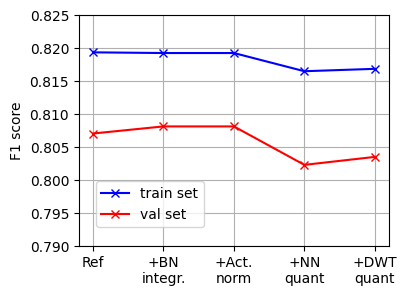

In [36]:
plt.rcParams['font.family'] = 'Arial'


# plot data
train_all = [F1t_ref[0],F1t_trans1[0],F1t_trans2[0],F1t_trans3[0],F1t_trans4[0]]
val_all = [F1v_ref[0],F1v_trans1[0],F1v_trans2[0],F1v_trans3[0],F1v_trans4[0]]
#trans_descr = ["reference","+integr. BN","+act. norm","+NN_quant","+DWT_quant"]
trans_descr = ["Ref","+BN\nintegr.","+Act.\nnorm","+NN\nquant","+DWT\nquant"]

# plot metrics
ax = plt.figure(figsize=[4,3])
plt.rcParams.update({'font.weight': 'normal'})
plt.plot(trans_descr,train_all,"b-x", label='train set')
plt.plot(trans_descr,val_all,"r-x", label='val set')
plt.grid(True,which='both')
plt.ylim((0.790,0.825))
#plt.ylabel("F1 score (CinC'17 definition)")
plt.ylabel("F1 score")
#plt.title(f"Normalization & Quantization of WVCNN design for SNN conversion\n (b={b} fractional bits)")
ax.legend(loc='lower left', bbox_to_anchor=(0.15, 0.15))
plt.savefig('wvcnn_norm_steps.png',dpi=600, bbox_inches = "tight")
plt.savefig('wvcnn_norm_steps.pdf',format='pdf', bbox_inches = "tight")

In [37]:
# Difference of classified samples between reference and "final" quantized version
print(len(F1t_ref[4]))
print((F1t_ref[4] != F1t_trans3[4]).sum())
print((F1t_ref[4] != F1t_trans4[4]).sum())

6822
tensor(105)
tensor(110)


In [38]:
F1t_quant_vec = []
F1v_quant_vec = []

for bb in range(16):
    dsetnq_train = CINC7Dataset('../data/custom/physionet2017_4classes.hdf5',train=True,transform=DWTnNorm(4,cnn_normed.input_lmbda,cnn_normed.input_dlta,quant=True,b=b))
    dsetnq_val = CINC7Dataset('../data/custom/physionet2017_4classes.hdf5',train=False,transform=DWTnNorm(4,cnn_normed.input_lmbda,cnn_normed.input_dlta,quant=True,b=b))
    dlnq_train = DataLoader(dsetnq_train, batch_size=bs, shuffle=False, num_workers=0)
    dlnq_val = DataLoader(dsetnq_val, batch_size=bs, shuffle=False, num_workers=0)

    cnn_quant = WVCNN4()
    cnn_quant.load_state_dict(cnn_normed.state_dict())
    #cnn_quant = cnn_normed
    cnn_quant.update_weights_with_quant(b=bb) # number of fractional bits for weights and bias
    cnn_quant.q_actb = bb # number of fractional bits for activations
    cnn_quant.quantize = True
    cnn_quant.normed = True
    cnn_quant.saturate = True
    cnn_quant.eval()
    F1t_quant_vec.append(eval_model(cnn_quant, dlnq_train,print_first=False))
    F1v_quant_vec.append(eval_model(cnn_quant, dlnq_val,print_first=False))

datt = [x1[0] for x1 in F1t_quant_vec]
datv = [x2[0] for x2 in F1v_quant_vec]

100%|██████████| 214/214 [00:23<00:00,  9.28it/s]


Total: 0.2503737509250641, N: 0.7511212825775146, AF: 0.0, O: 0.0, ACC: 0.6014365288771621


100%|██████████| 54/54 [00:05<00:00, 10.67it/s]


Total: 0.24213014543056488, N: 0.7263904213905334, AF: 0.0, O: 0.0, ACC: 0.5703399765533411


100%|██████████| 214/214 [00:20<00:00, 10.36it/s]


Total: 0.2503737509250641, N: 0.7511212825775146, AF: 0.0, O: 0.0, ACC: 0.6014365288771621


100%|██████████| 54/54 [00:05<00:00, 10.52it/s]


Total: 0.24213014543056488, N: 0.7263904213905334, AF: 0.0, O: 0.0, ACC: 0.5703399765533411


100%|██████████| 214/214 [00:21<00:00,  9.81it/s]


Total: 0.2503737509250641, N: 0.7511212825775146, AF: 0.0, O: 0.0, ACC: 0.6014365288771621


100%|██████████| 54/54 [00:05<00:00, 10.52it/s]


Total: 0.24213014543056488, N: 0.7263904213905334, AF: 0.0, O: 0.0, ACC: 0.5703399765533411


100%|██████████| 214/214 [00:21<00:00,  9.84it/s]


Total: 0.2545405626296997, N: 0.7493056654930115, AF: 0.006144393235445023, O: 0.00817160401493311, ACC: 0.5955731457050718


100%|██████████| 54/54 [00:05<00:00, 10.43it/s]


Total: 0.2426127791404724, N: 0.7238383293151855, AF: 0.0, O: 0.004000000189989805, ACC: 0.563305978898007


100%|██████████| 214/214 [00:22<00:00,  9.71it/s]


Total: 0.29297104477882385, N: 0.7208634614944458, AF: 0.0660276859998703, O: 0.09202194958925247, ACC: 0.5554089709762533


100%|██████████| 54/54 [00:05<00:00, 10.38it/s]


Total: 0.28875741362571716, N: 0.6994713544845581, AF: 0.08191126585006714, O: 0.08488964289426804, ACC: 0.5275498241500586


100%|██████████| 214/214 [00:21<00:00,  9.99it/s]


Total: 0.009713453240692616, N: 0.0, AF: 0.0, O: 0.029140358790755272, ACC: 0.035913221929053066


100%|██████████| 54/54 [00:05<00:00, 10.20it/s]


Total: 0.008939974941313267, N: 0.0, AF: 0.0, O: 0.026819923892617226, ACC: 0.041617819460726846


100%|██████████| 214/214 [00:22<00:00,  9.68it/s]


Total: 0.12637512385845184, N: 0.000487329438328743, AF: 0.0, O: 0.37863802909851074, ACC: 0.202726473175022


100%|██████████| 54/54 [00:05<00:00,  9.80it/s]


Total: 0.1303243488073349, N: 0.002053388161584735, AF: 0.0, O: 0.3889196813106537, ACC: 0.21805392731535755


100%|██████████| 214/214 [00:22<00:00,  9.37it/s]


Total: 0.21148984134197235, N: 0.044549763202667236, AF: 0.17416545748710632, O: 0.4157542884349823, ACC: 0.26854294928173555


100%|██████████| 54/54 [00:05<00:00,  9.28it/s]


Total: 0.20980769395828247, N: 0.03212851285934448, AF: 0.18136020004749298, O: 0.41593438386917114, ACC: 0.26670574443141853


100%|██████████| 214/214 [00:23<00:00,  9.04it/s]


Total: 0.5138188004493713, N: 0.8453429341316223, AF: 0.09508197009563446, O: 0.6010316014289856, ACC: 0.7150395778364116


100%|██████████| 54/54 [00:05<00:00,  9.63it/s]


Total: 0.4816098213195801, N: 0.813128650188446, AF: 0.0648648664355278, O: 0.566835880279541, ACC: 0.6705744431418523


100%|██████████| 214/214 [00:23<00:00,  9.08it/s]


Total: 0.7728462219238281, N: 0.8989530205726624, AF: 0.709583044052124, O: 0.7100027799606323, ACC: 0.8218997361477572


100%|██████████| 54/54 [00:05<00:00,  9.25it/s]


Total: 0.7552902698516846, N: 0.8782742619514465, AF: 0.7246376872062683, O: 0.6629588603973389, ACC: 0.7930832356389215


100%|██████████| 214/214 [00:24<00:00,  8.75it/s]


Total: 0.7837166786193848, N: 0.868328332901001, AF: 0.7666399478912354, O: 0.7161816358566284, ACC: 0.8048959249486954


100%|██████████| 54/54 [00:05<00:00,  9.42it/s]


Total: 0.7658278346061707, N: 0.8308038115501404, AF: 0.7847411632537842, O: 0.6819383502006531, ACC: 0.7690504103165299


100%|██████████| 214/214 [00:23<00:00,  9.14it/s]


Total: 0.81606525182724, N: 0.9156990051269531, AF: 0.7817703485488892, O: 0.7507263422012329, ACC: 0.8554676048079742


100%|██████████| 54/54 [00:05<00:00,  9.47it/s]


Total: 0.7969120144844055, N: 0.8934707641601562, AF: 0.7882353067398071, O: 0.7090300917625427, ACC: 0.824736225087925


100%|██████████| 214/214 [00:24<00:00,  8.82it/s]


Total: 0.8168550133705139, N: 0.9186782240867615, AF: 0.7810158133506775, O: 0.7508710622787476, ACC: 0.85649369686309


100%|██████████| 54/54 [00:05<00:00,  9.16it/s]


Total: 0.8035113215446472, N: 0.8981619477272034, AF: 0.7988826632499695, O: 0.7134894132614136, ACC: 0.8288393903868698


100%|██████████| 214/214 [00:23<00:00,  8.93it/s]


Total: 0.819617509841919, N: 0.9176993370056152, AF: 0.7841788530349731, O: 0.7569743990898132, ACC: 0.8579595426561126


100%|██████████| 54/54 [00:05<00:00,  9.77it/s]


Total: 0.8058991432189941, N: 0.897372305393219, AF: 0.7988338470458984, O: 0.7214912176132202, ACC: 0.8305978898007034


100%|██████████| 214/214 [00:23<00:00,  8.92it/s]


Total: 0.8190308213233948, N: 0.9174268841743469, AF: 0.7850467562675476, O: 0.7546189427375793, ACC: 0.8572266197596012


100%|██████████| 54/54 [00:05<00:00,  9.15it/s]


Total: 0.8071655631065369, N: 0.89806067943573, AF: 0.801152765750885, O: 0.7222831845283508, ACC: 0.8311840562719812


100%|██████████| 214/214 [00:23<00:00,  9.03it/s]


Total: 0.8187406659126282, N: 0.9169489741325378, AF: 0.7860187292098999, O: 0.7532542943954468, ACC: 0.8567868660216945


100%|██████████| 54/54 [00:05<00:00,  9.61it/s]

Total: 0.8060925006866455, N: 0.8972705006599426, AF: 0.8023256063461304, O: 0.7186813354492188, ACC: 0.8300117233294255


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

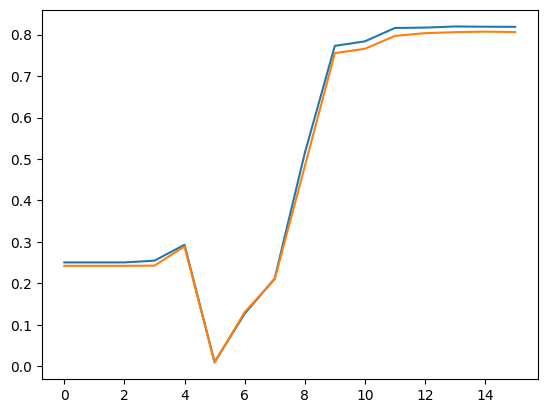

In [39]:
plt.plot(datt)
plt.plot(datv)

findfont: Font family 'Arial' not found.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


[tensor(0.4816, dtype=torch.float32), tensor(0.7553, dtype=torch.float32), tensor(0.7658, dtype=torch.float32), tensor(0.7969, dtype=torch.float32), tensor(0.8035, dtype=torch.float32), tensor(0.8059, dtype=torch.float32), tensor(0.8072, dtype=torch.float32), tensor(0.8061, dtype=torch.float32)]


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

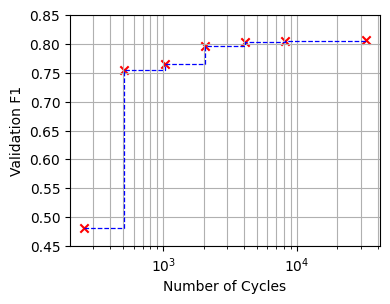

In [40]:
print(datv[8:])

datx = np.logspace(0, 15, num=16, endpoint=True, base=2.0, dtype=None, axis=0)
paretoidx = [8,9,10,11,12,13,15]

plotx = [datx[ii] for ii in paretoidx]
ploty = [datv[ii] for ii in paretoidx]

ax = plt.figure(figsize=[4,3])
plt.step(plotx,ploty, where='post',linestyle='--',c='b',linewidth=0.9)
plt.scatter(plotx,ploty,c='r',marker='x')


plt.xlabel('Number of Cycles')
plt.ylabel('Validation F1')
#plt.xlim([1e2,1e5])
plt.ylim([0.45,0.85])
plt.grid(which='both')
plt.xscale('log')

plt.savefig('timeencode_qosvscyc.png',dpi=600, bbox_inches = "tight")
plt.savefig('timeencode_qosvscyc.pdf',format='pdf', bbox_inches = "tight")

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

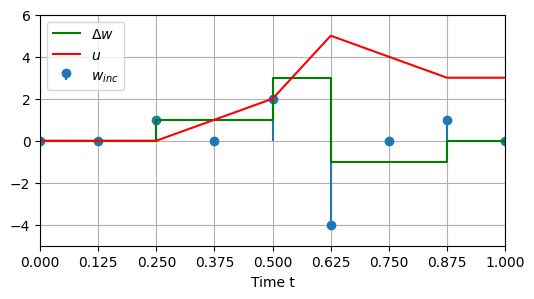

In [41]:
x0 = np.array([2,4,5,7])*0.1
w = np.array([1,2,-4,1])

x1 = np.array([ 0, 0, 1, 0, 2,-4, 0, 1, 0])
x2 = np.array([ 0, 0, 1, 1, 3,-1,-1, 0, 0])
x3 = np.array([ 0, 0, 0, 1, 2, 5, 4, 3, 3])

x = np.arange(0,1.1,0.125)


ax = plt.figure(figsize=[6,3])
plt.stem(x,x1,basefmt=" ")
plt.step(x,x2,'g', where='post')
plt.plot(x,x3,'r')
plt.xlim([0,1])
plt.ylim([-5,6])
plt.xlabel('Time t')
#plt.ylabel('')
plt.grid(which='both')
plt.legend([r'$\Delta w$',r'$u$',r'$w_{inc}$'])
plt.xticks(x)

plt.savefig('timeencode_min_example.png',dpi=600, bbox_inches = "tight")
plt.savefig('timeencode_min_example.pdf',format='pdf', bbox_inches = "tight")


In [42]:
x

array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ])

In [43]:
# Output of quantized version in pytorch (!! NOT EQUAL to Matlab version due to rounding scheme !!)
# roundig scheme should be fixed via custom round_halfup
dwt_in = dwts[2].unsqueeze(0).unsqueeze(0) * cnn_normed.input_lmbda + cnn_normed.input_dlta
res = cnn_quant(dwt_in)
res
#dwts[2]

tensor([[ 0.0966, -0.0689,  0.0584, -0.0837]])

In [44]:
# d = next(iter(dln_train))
# dq = next(iter(dlnq_train))

# # rough distribution of fixed-point DWT (weights and activations of filter quantized in each stage -> 4 stages) and floating-point DWT
# # one batch
# plt.figure(0,figsize=[25,10])
# ax1 = plt.subplot(1, 2, 1)
# plt.hist(d['data_in'][0].flatten(),range=(0.45,0.5),bins=1000);
# plt.hist(dq['data_in'][0].flatten(),range=(0.45,0.5),bins=1000);
# plt.grid()

# ax2 = plt.subplot(1, 2, 2)
# plt.hist(d['data_in'][0].flatten(),range=(0.45,0.5),bins=1000);
# plt.hist(dq['data_in'][0].flatten(),range=(0.45,0.5),bins=1000);
# plt.ylim([0, 35])
# plt.grid()

In [45]:
# def q(x,b):
#     # no saturation!
#     result = torch.round(x * 2**b) / 2**b
#     return result 

# db2wvlt = pywt.Wavelet('db2')
# # floating point values in python are stored as double precision values
# print(type(db2wvlt.dec_lo[0]))


# dlo_fp64 = np.array(db2wvlt.dec_lo,dtype=np.float64)
# dlo_fp64 = torch.from_numpy(dlo_fp64)
# dhi_fp64 = np.array(db2wvlt.dec_hi,dtype=np.float64)
# dhi_fp64 = torch.from_numpy(dhi_fp64)
# print(dlo_fp64.dtype)
# print(dlo_fp64)
# print(dhi_fp64)
# dlo = q(dlo_fp64,b)
# dhi = q(dhi_fp64,b)
# print(dlo.dtype)
# print(dlo)
# print(dhi)

# edlo_abs = torch.abs(dlo-dlo_fp64)
# edlo_rmse = torch.sqrt(torch.mean(edlo_abs**2))
# edhi_abs = torch.abs(dhi-dhi_fp64)
# edhi_rmse = torch.sqrt(torch.mean(edhi_abs**2))
# print(f'Lowpass Coefficient RMSE due to quantization: {edlo_rmse}')
# print(f'Highpass Coefficient RMSE due to quantization: {edhi_rmse}')
# torch.zeros((1,18000)).dtype

In [46]:
# # Test rounding fcn
# import math
# x = -0.5

# def round_halfup(x):
#     return math.ceil(math.floor(2*x)/2)

# test = round_halfup(x)
# test